[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/tushar-mahalya/Custom-ChatGPT/blob/master/EDA.ipynb)

In [1]:
import os
import tensorflow as tf
#import nltk
import pandas as pd
import datetime as dt
from ast import literal_eval
import numpy as np

import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import seaborn as sns

import transformers as trf
from transformers import pipeline, AutoModel

os.chdir('/home/studio-lab-user/sagemaker-studiolab-notebooks/Custom ChatGPT')
#from src.text_preprocessor import preprocess_text_data

In [2]:
# Loading Datasets
posts_df = pd.read_csv('data/Top_Posts.csv')
comments_df = pd.read_csv('data/Top_Posts_Comments.csv')

In [3]:
# Joning Comments with their respective Post ID
comments_posts_merged = posts_df.merge(comments_df, on = 'post_id', how = 'left')

# Deleting rows that doesn't contain any Comment
comments_posts_merged = comments_posts_merged[~comments_posts_merged['comment'].isnull()]

# Pre-Processing Comments of merged dataset
#final_data = preprocess_text_data(comments_posts_merged, 'comment')
#final_data.to_csv('data/Reddit Data (Preprocessed).csv', index = False) # Saving Final Dataset
final_data = pd.read_csv('data/Reddit Data (Preprocessed).csv')

In [4]:
final_data.shape

(223158, 13)

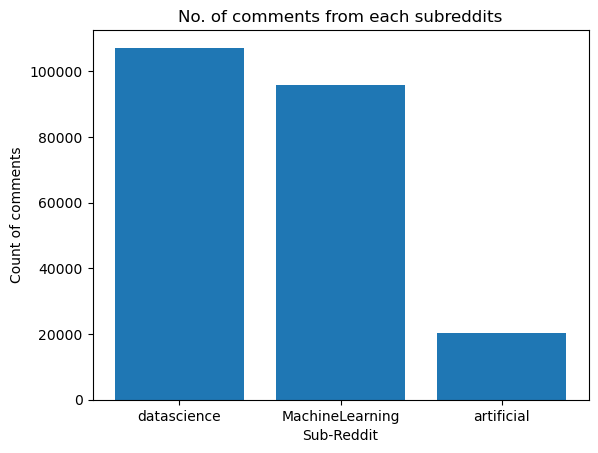

In [7]:
comment_count = dict(final_data['subreddit'].value_counts())
plt.bar(comment_count.keys(), comment_count.values())
plt.title('No. of comments from each subreddits')
plt.xlabel('Sub-Reddit')
plt.ylabel('Count of comments')
plt.show()

In [8]:
final_data['comment_tokens'] = final_data['comment_tokens'].apply(lambda token: literal_eval(token))

In [9]:
# Assuming the tokenized word list column is named 'comment_tokens'
word_freq = nltk.FreqDist([word for tokens in final_data['comment_tokens'] for word in tokens if len(word) >= 2])

In [10]:
# Print the most common words and their frequencies
word_freq_dict = {}
for word, frequency in word_freq.most_common(50):
    word_freq_dict[word] = frequency

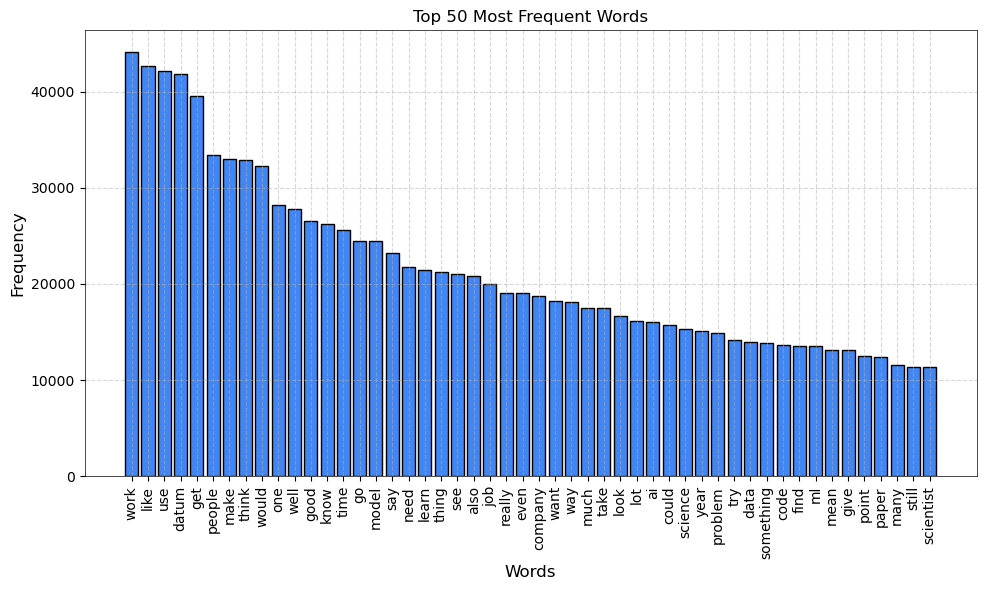

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

# Set the bar color and edge color
bar_color = '#4286f4'
edge_color = '#000000'

# Plot the bar chart
ax.bar(word_freq_dict.keys(), word_freq_dict.values(), color=bar_color, edgecolor=edge_color)

# Customize the plot appearance
ax.set_title('Top 50 Most Frequent Words')
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=90)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.5)


# Add a background color to the plot
ax.set_facecolor('#f2f2f2')

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)
    spine.set_edgecolor(edge_color)

# Add a shadow effect to the plot
ax.set_box_aspect(0.5)
ax.set_frame_on(True)
ax.patch.set_visible(False)



# Increase the font size of the axis labels
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
def getCompleteText(df: pd.DataFrame, year: int):
    complete_txt = str()
    for comment in list(df[df['year'] == year]['comment']):
        complete_txt += str(comment)
    return complete_txt

In [13]:
comm_year = final_data[['comment_preprocessed', 'year']]
set(comm_year['year'])

{2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023}

In [14]:
def plotWordCloud(text: str):    
    wordcloud = WordCloud(width=600, height=300, background_color='black',
                          colormap='rainbow', max_words=50, contour_width=3, contour_color='red'
                          , prefer_horizontal=0.9,
                          random_state=42).generate(text)
    return wordcloud

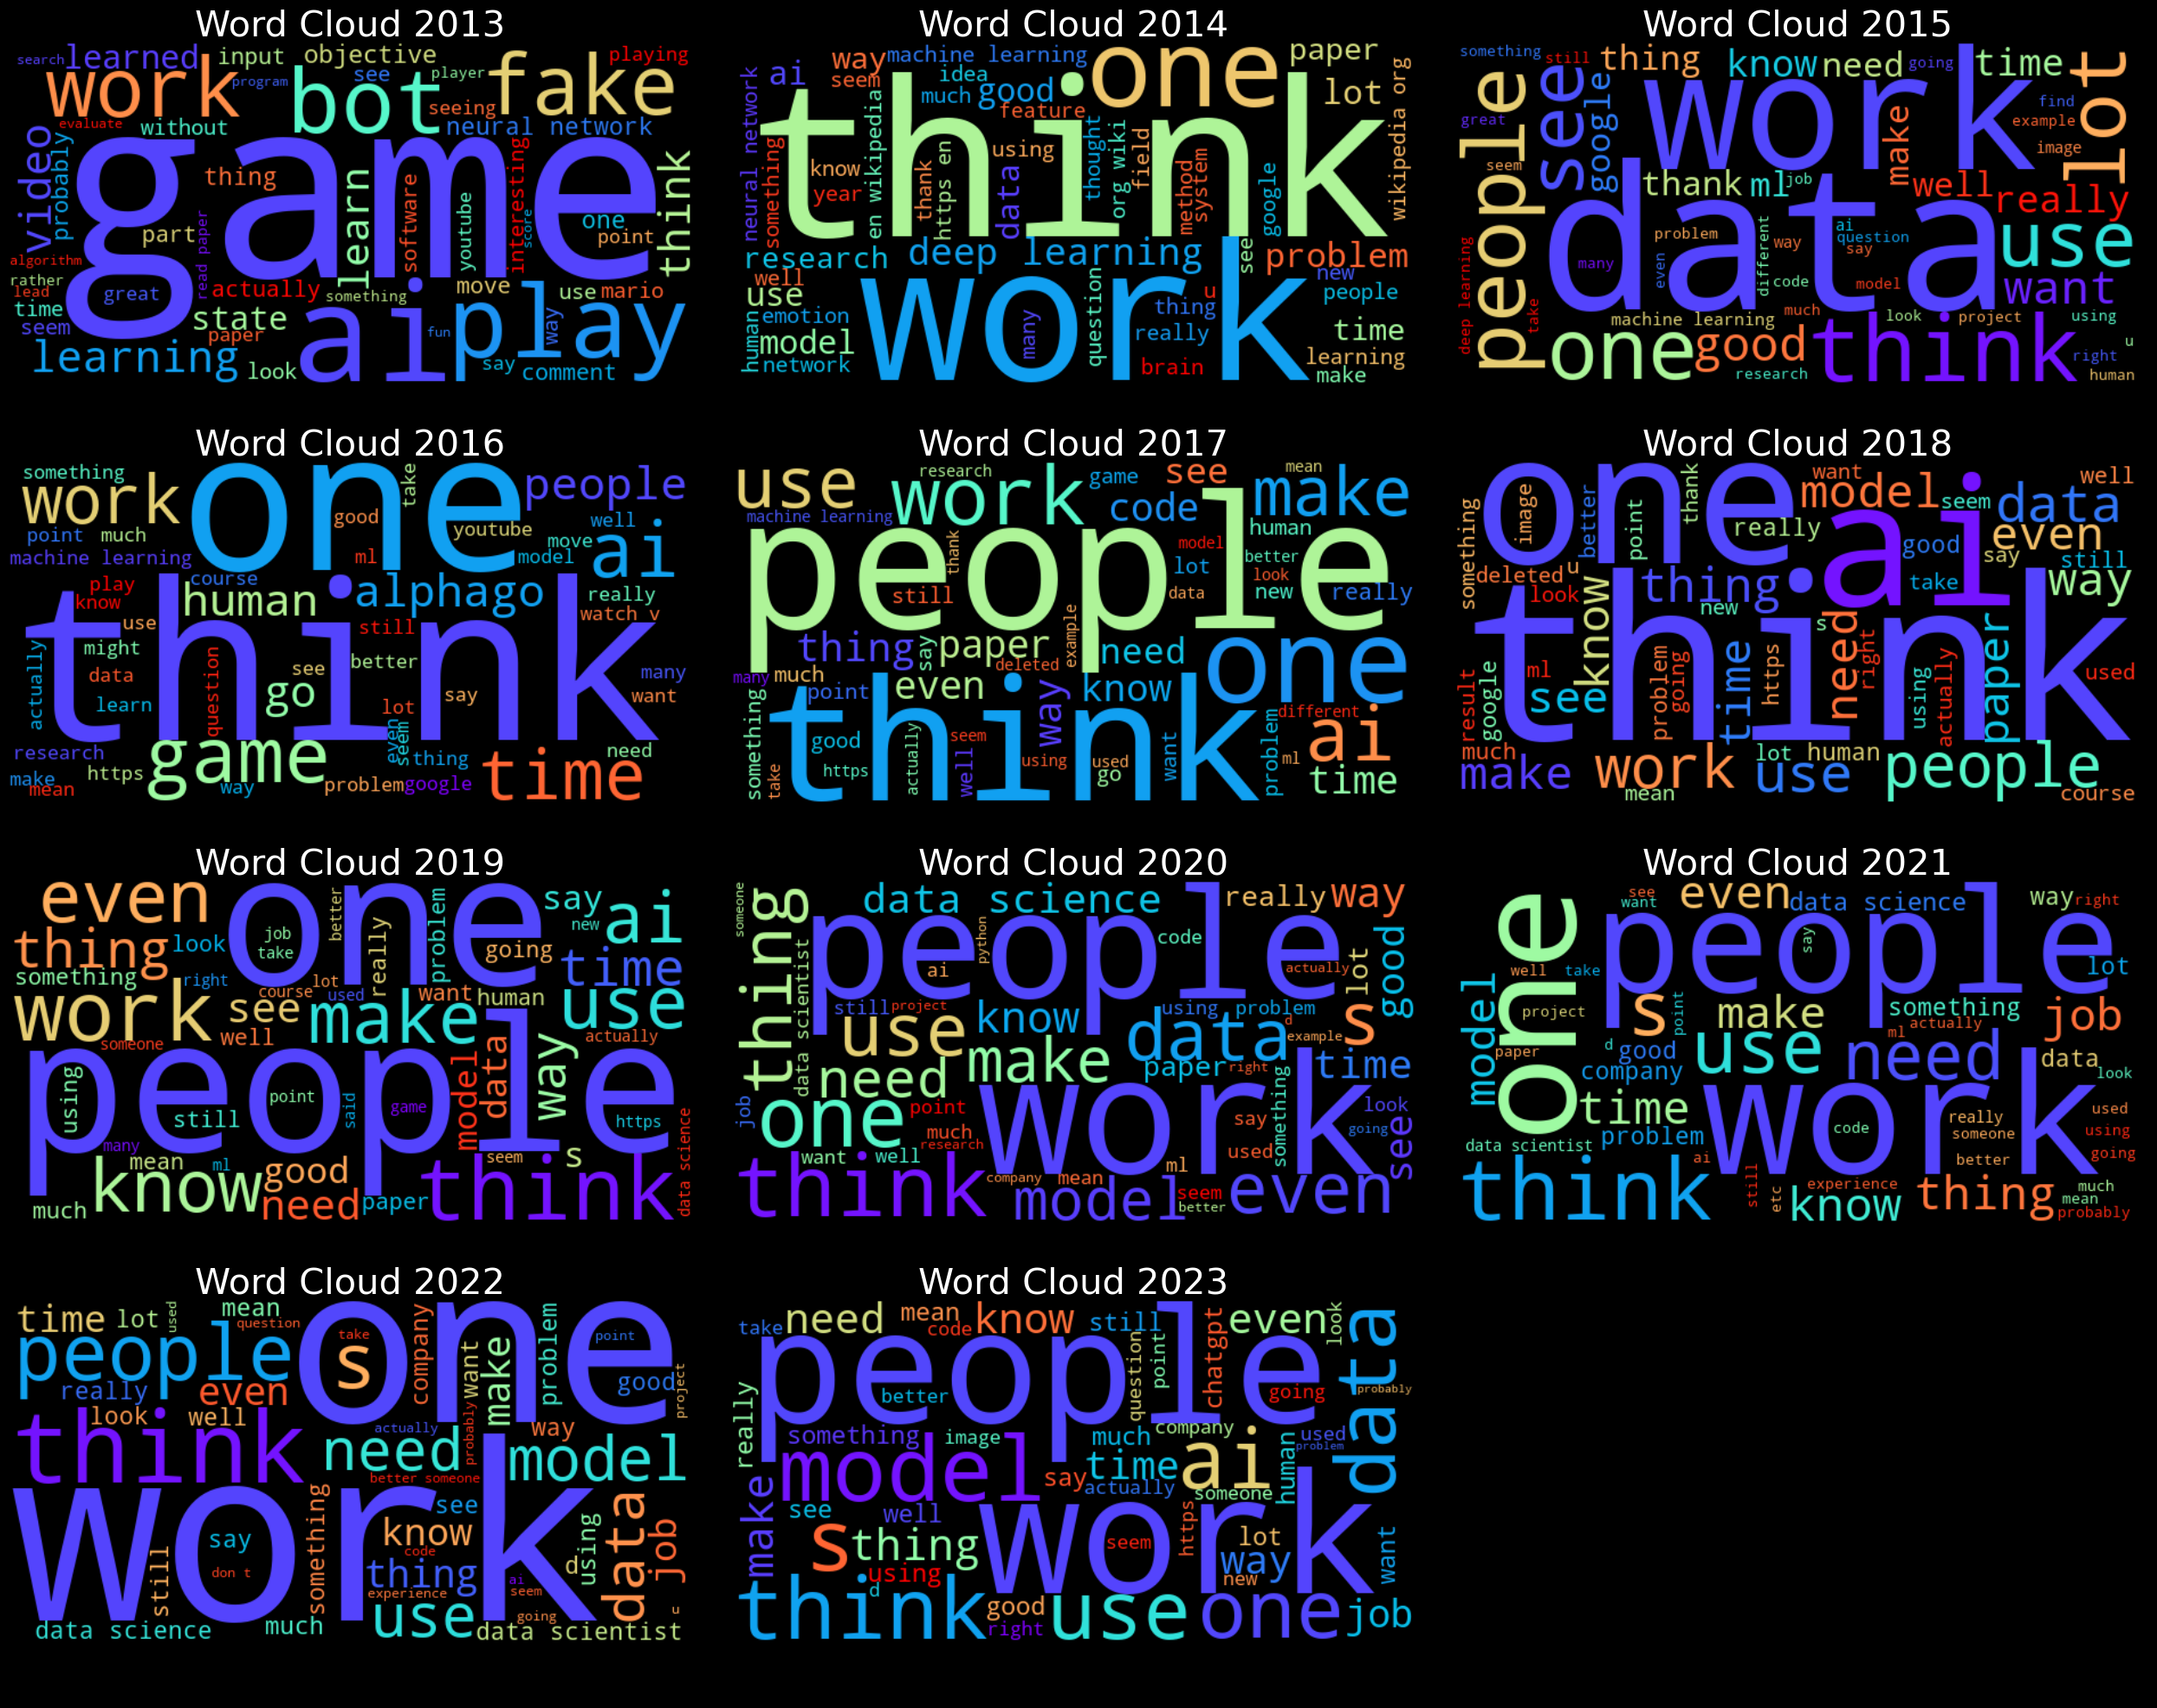

In [15]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 20))
fig.patch.set_facecolor('black')
ax = np.ravel(axs)
for i, year in zip(range(12), range(2013,2024)):
    text = getCompleteText(final_data, year)
    ax[i].imshow(plotWordCloud(text), interpolation='bilinear')
    ax[i].set_axis_off()
    ax[i].set_title(f'Word Cloud {year}', fontsize=30, color = 'white')
ax[11].set_facecolor('black')
plt.tight_layout()
plt.show()

## Sentiment Analysis
To get a better idea about the sentiment of our Reddit comments we will use pre-trained [RoBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) -base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis.

In [4]:
from src.models import SentimentClassifier, EmotionClassifier

In [5]:
sentiment_classifier = SentimentClassifier()
emotion_classifier = EmotionClassifier()

In [6]:
final_data['comment_preprocessed'] = final_data['comment_preprocessed'].astype(str)

In [8]:
sentiment_classifier.getSentiment('This is the baddest mf I know')

('Negative', 3.0605)

In [7]:
df1 = final_data['comment_preprocessed'].iloc[:44631]
df2 = final_data['comment_preprocessed'].iloc[44631:89262]
df3 = final_data['comment_preprocessed'].iloc[89262:133893]
df4 = final_data['comment_preprocessed'].iloc[133893:178524]
df5 = final_data['comment_preprocessed'].iloc[178524:]

In [8]:
kim1 = pd.DataFrame()

In [ ]:
kim1['emotion'] = df1.apply(lambda comment: emotion_classifier.getEmotion(comment)[0])

In [ ]:
kim1['sentiment'] = df1.apply(lambda comment: sentiment_classifier.getSentiment(comment)[0])

In [ ]:
final_data[['sentiment', 'emotion']].to_csv('emotion_sentiment.csv', index = False)

In [7]:
final_data['comment_preprocessed'].iloc[:44631]

0        twitter thread code background removal u net q...
1                                      future explode head
2                       simple yet useful thank share code
3                         almost guarantee apple copy idea
4        ohh nightmare make stable product enough drive...
                               ...                        
44626    think youtube star think publish paper like sh...
44627    think time ban hammer ban content insult great...
44628    think sleazy fraud industry ml community ostra...
44629    act like make break career siraj move onto nex...
44630    make sound potentially minor part look siraj p...
Name: comment_preprocessed, Length: 44631, dtype: object